# Model Comparison Lab

In this lab we will compare the performance of all the models we have learned about so far, using the car evaluation dataset.

## 1. Prepare the data

The [car evaluation dataset](https://archive.ics.uci.edu/ml/machine-learning-databases/car/) is in the assets/datasets folder. By now you should be very familiar with this dataset.

1. Load the data into a pandas dataframe
- Encode the categorical features properly: define a map that preserves the scale (assigning smaller numbers to words indicating smaller quantities)
- Separate features from target into X and y

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
%matplotlib inline

In [2]:
df = pd.read_csv('./../../assets/datasets/car.csv')
df.head()

# Clean data, assign values to text features

mapper = {
    'low' : 1,
    'small': 1,
    'med' : 2,
    'high': 3,
    'big' : 3,
    'vhigh': 4,
    'unacc': 1,
    'acc': 2,
    'good': 3,
    'vgood': 4,
    '2': 2,
    '3': 3,
    '4': 4,
    '5more': 5,
    'more': 6,
}

df = df.applymap(lambda x : mapper[x])
df.head()

,buying,maint,doors,persons,lug_boot,safety,acceptability
0,4,4,2,2,1,1,1
1,4,4,2,2,1,2,1
2,4,4,2,2,1,3,1
3,4,4,2,2,2,1,1
4,4,4,2,2,2,2,1


## 2. Useful preparation

Since we will compare several models, let's write a couple of helper functions.

1. Separate X and y between a train and test set, using 30% test set, random state = 42
    - make sure that the data is shuffled and stratified
2. Define a function called `evaluate_model`, that trains the model on the train set, tests it on the test, calculates:
    - accuracy score
    - confusion matrix
    - classification report
3. Initialize a global dictionary to store the various models for later retrieval


In [3]:
X = df.drop('acceptability',axis = 1)
y = df['acceptability']

# Separate X and y between a train and test set, using 30% test set, random state = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify = y)

# Define a function called evaluate_model, that trains the model on the train set, tests it on the test, calculates:
# accuracy score, confusion matrix, classification report

def evaluate_model(model):
    # Fit Model
    model.fit(X_train, y_train)
    # Generate Predictions
    predictions = model.predict(X_test)
    # Determine Accuracy
    print 'Accuracy:', model.score(X_test, y_test)
    # Create Confusion Matrix
    con_matrix = pd.DataFrame(confusion_matrix(predictions, y_test))
    con_matrix.columns = ['pred_acc', 'pred_good', 'pred_unacc', 'pred_vgood']
    con_matrix.index = ['acc', 'good', 'unacc', 'vgood']
    print con_matrix
    print classification_report(predictions, y_test)
    return model

# Initialize a global dictionary to store the various models for later retrieval
dicty_models = {}

## 3.a KNN

Let's start with `KNeighborsClassifier`.

1. Initialize a KNN model
- Evaluate it's performance with the function you previously defined
- Find the optimal value of K using grid search
    - Be careful on how you perform the cross validation in the grid search

In [4]:
def grid_searcher(model, pg):
    gs = GridSearchCV(model, param_grid=pg, cv=5)
    gs.fit(X_train, y_train)
    
    print gs.best_params_

In [5]:
# Initialize a KNN model
# Evaluate it's performance with the function you previously defined
dicty_models['KNN'] = evaluate_model(KNeighborsClassifier())

Accuracy: 0.938342967245
       pred_acc  pred_good  pred_unacc  pred_vgood
acc         357          8           1           0
good          6        106          11           4
unacc         0          1           9           1
vgood         0          0           0          15
             precision    recall  f1-score   support

          1       0.98      0.98      0.98       366
          2       0.92      0.83      0.88       127
          3       0.43      0.82      0.56        11
          4       0.75      1.00      0.86        15

avg / total       0.95      0.94      0.94       519



In [6]:
# Find the optimal value of K using grid search
pg = {'n_neighbors': [x for x in range(1,20)]}

gs = GridSearchCV(dicty_models['KNN'], param_grid=pg, cv=5)

gs.fit(X_train, y_train)

print gs.best_params_

{'n_neighbors': 5}


In [7]:
dicty_models['KNN'] = evaluate_model(KNeighborsClassifier().set_params(n_neighbors = 5))

Accuracy: 0.938342967245
       pred_acc  pred_good  pred_unacc  pred_vgood
acc         357          8           1           0
good          6        106          11           4
unacc         0          1           9           1
vgood         0          0           0          15
             precision    recall  f1-score   support

          1       0.98      0.98      0.98       366
          2       0.92      0.83      0.88       127
          3       0.43      0.82      0.56        11
          4       0.75      1.00      0.86        15

avg / total       0.95      0.94      0.94       519



## 3.b Bagging + KNN

Now that we have found the optimal K, let's wrap `KNeighborsClassifier` in a BaggingClassifier and see if the score improves.

1. Wrap the KNN model in a Bagging Classifier
- Evaluate performance
- Do a grid search only on the bagging classifier params

In [8]:
dicty_models['bagging_knn'] = evaluate_model(BaggingClassifier(dicty_models['KNN'].set_params(n_neighbors=5)))

Accuracy: 0.93063583815
       pred_acc  pred_good  pred_unacc  pred_vgood
acc         354          9           1           0
good          8        104           9           5
unacc         1          2          11           1
vgood         0          0           0          14
             precision    recall  f1-score   support

          1       0.98      0.97      0.97       364
          2       0.90      0.83      0.86       126
          3       0.52      0.73      0.61        15
          4       0.70      1.00      0.82        14

avg / total       0.94      0.93      0.93       519



In [9]:
# Find the optimal value of K using grid search
pg = {'n_estimators': [4, 8, 10, 12, 15],
     'bootstrap': [True, False],
     'bootstrap_features': [True, False]}

grid_searcher(dicty_models['bagging_knn'],pg)
    


{'n_estimators': 15, 'bootstrap': True, 'bootstrap_features': False}


In [10]:
dicty_models['bagging_knn'] = evaluate_model(BaggingClassifier(dicty_models['KNN'].set_params(n_neighbors=5)).set_params(n_estimators = 12, bootstrap = True, bootstrap_features = False))

Accuracy: 0.926782273603
       pred_acc  pred_good  pred_unacc  pred_vgood
acc         354         11           0           0
good          9        101           9           3
unacc         0          3          12           3
vgood         0          0           0          14
             precision    recall  f1-score   support

          1       0.98      0.97      0.97       365
          2       0.88      0.83      0.85       122
          3       0.57      0.67      0.62        18
          4       0.70      1.00      0.82        14

avg / total       0.93      0.93      0.93       519



## 4. Logistic Regression

Let's see if logistic regression performs better

1. Initialize LR and test on Train/Test set
- Find optimal params with Grid Search
- See if Bagging improves the score

In [11]:
dicty_models['log_reg'] = evaluate_model(LogisticRegression())

Accuracy: 0.763005780347
       pred_acc  pred_good  pred_unacc  pred_vgood
acc         346         65           6           0
good         11         48          13          19
unacc         4          2           1           0
vgood         2          0           1           1
             precision    recall  f1-score   support

          1       0.95      0.83      0.89       417
          2       0.42      0.53      0.47        91
          3       0.05      0.14      0.07         7
          4       0.05      0.25      0.08         4

avg / total       0.84      0.76      0.80       519



In [12]:
pg = {'penalty': ['l1','l2'],
     'C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0],
     }

grid_searcher(dicty_models['log_reg'],pg)
    

{'penalty': 'l1', 'C': 1000.0}


In [13]:
dicty_models['log_reg'] = (dicty_models['log_reg'].set_params(penalty = 'l1', C=100))

In [14]:
dicty_models['bagging_log_reg'] = evaluate_model(BaggingClassifier(dicty_models['log_reg'].set_params(penalty='l1', C=100.0)))

pg = {'n_estimators': [4, 8, 10, 12, 15],
     'bootstrap': [True, False],
     'bootstrap_features': [True, False]}


grid_searcher(dicty_models['bagging_log_reg'], pg)

Accuracy: 0.797687861272
       pred_acc  pred_good  pred_unacc  pred_vgood
acc         342         56           5           0
good         15         57          11          10
unacc         4          2           5           0
vgood         2          0           0          10
             precision    recall  f1-score   support

          1       0.94      0.85      0.89       403
          2       0.50      0.61      0.55        93
          3       0.24      0.45      0.31        11
          4       0.50      0.83      0.62        12

avg / total       0.84      0.80      0.81       519

{'n_estimators': 15, 'bootstrap': True, 'bootstrap_features': False}


In [15]:
dicty_models['bagging_log_reg'] = evaluate_model(dicty_models['bagging_log_reg'].set_params(n_estimators=10, bootstrap=True, bootstrap_features=False))


Accuracy: 0.789980732177
       pred_acc  pred_good  pred_unacc  pred_vgood
acc         344         57           6           0
good         14         56          14          10
unacc         3          2           0           0
vgood         2          0           1          10
             precision    recall  f1-score   support

          1       0.95      0.85      0.89       407
          2       0.49      0.60      0.54        94
          3       0.00      0.00      0.00         5
          4       0.50      0.77      0.61        13

avg / total       0.84      0.79      0.81       519



## 5. Decision Trees

Let's see if Decision Trees perform better

1. Initialize DT and test on Train/Test set
- Find optimal params with Grid Search
- See if Bagging improves the score

In [16]:
dicty_models['decision_tree'] = evaluate_model(DecisionTreeClassifier())

Accuracy: 0.957610789981
       pred_acc  pred_good  pred_unacc  pred_vgood
acc         360         11           1           0
good          3        102           4           1
unacc         0          2          16           0
vgood         0          0           0          19
             precision    recall  f1-score   support

          1       0.99      0.97      0.98       372
          2       0.89      0.93      0.91       110
          3       0.76      0.89      0.82        18
          4       0.95      1.00      0.97        19

avg / total       0.96      0.96      0.96       519



In [21]:
pg = {
    'criterion': ['gini', 'entropy'],
    'max_features': [None, 1, 2, 3],
    'max_depth': [None, 4, 5, 6, 7, 8, 9],
    'max_leaf_nodes': [None, 4, 5, 6, 7, 8, 9]
}

grid_searcher(dicty_models['decision_tree'], pg)

{'max_features': None, 'max_leaf_nodes': None, 'criterion': 'entropy', 'max_depth': None}


In [17]:
dicty_models['decision_tree'] = evaluate_model(dicty_models['decision_tree'].set_params(max_features = None, max_leaf_nodes = None, criterion = 'entropy', max_depth = None))

Accuracy: 0.969171483622
       pred_acc  pred_good  pred_unacc  pred_vgood
acc         360          9           0           0
good          2        105           2           1
unacc         1          1          19           0
vgood         0          0           0          19
             precision    recall  f1-score   support

          1       0.99      0.98      0.98       369
          2       0.91      0.95      0.93       110
          3       0.90      0.90      0.90        21
          4       0.95      1.00      0.97        19

avg / total       0.97      0.97      0.97       519



## 6. Support Vector Machines

Let's see if SVM perform better

1. Initialize SVM and test on Train/Test set
- Find optimal params with Grid Search
- See if Bagging improves the score

In [18]:
dicty_models['SVM'] = evaluate_model(SVC())

Accuracy: 0.949903660886
       pred_acc  pred_good  pred_unacc  pred_vgood
acc         355          6           0           0
good          8        108           7           2
unacc         0          1          12           0
vgood         0          0           2          18
             precision    recall  f1-score   support

          1       0.98      0.98      0.98       361
          2       0.94      0.86      0.90       125
          3       0.57      0.92      0.71        13
          4       0.90      0.90      0.90        20

avg / total       0.96      0.95      0.95       519



In [ ]:
pg = {
    'C': [1.0, 10.0, 100.0, 1000.0, 10000.0],
    'kernel': ['rbf', 'linear', 'poly'],
    'degree': [1, 2, 3, 4, 5]
}

grid_searcher(dicty_models['SVM'], pg)

In [19]:
dicty_models['SVM'] = evaluate_model(SVC(kernel='poly', C=1000.0, degree=3))


Accuracy: 0.938342967245
       pred_acc  pred_good  pred_unacc  pred_vgood
acc         353         14           0           0
good         10         99           6           0
unacc         0          2          15           0
vgood         0          0           0          20
             precision    recall  f1-score   support

          1       0.97      0.96      0.97       367
          2       0.86      0.86      0.86       115
          3       0.71      0.88      0.79        17
          4       1.00      1.00      1.00        20

avg / total       0.94      0.94      0.94       519



## 7. Random Forest & Extra Trees

Let's see if Random Forest and Extra Trees perform better

1. Initialize RF and ET and test on Train/Test set
- Find optimal params with Grid Search

In [20]:
dicty_models['Random_Forest'] = evaluate_model(RandomForestClassifier())

Accuracy: 0.95183044316
       pred_acc  pred_good  pred_unacc  pred_vgood
acc         356          6           1           0
good          6        106           4           2
unacc         1          2          15           1
vgood         0          1           1          17
             precision    recall  f1-score   support

          1       0.98      0.98      0.98       363
          2       0.92      0.90      0.91       118
          3       0.71      0.79      0.75        19
          4       0.85      0.89      0.87        19

avg / total       0.95      0.95      0.95       519



In [21]:
pg = {
    'bootstrap': [True, False],
    'criterion':['gini', 'entropy'],
    'max_depth': [None, 3, 5, 7, 9, 15]
}

grid_searcher(dicty_models['Random_Forest'], pg)

{'bootstrap': False, 'criterion': 'gini', 'max_depth': 15}


In [23]:
dicty_models['Random_Forest'] = evaluate_model(RandomForestClassifier(bootstrap=False, criterion='entropy'))

Accuracy: 0.965317919075
       pred_acc  pred_good  pred_unacc  pred_vgood
acc         360          7           0           0
good          3        107           6           1
unacc         0          0          15           0
vgood         0          1           0          19
             precision    recall  f1-score   support

          1       0.99      0.98      0.99       367
          2       0.93      0.91      0.92       117
          3       0.71      1.00      0.83        15
          4       0.95      0.95      0.95        20

avg / total       0.97      0.97      0.97       519



In [24]:
dicty_models['Random_Forest_ET'] = evaluate_model(ExtraTreesClassifier())


Accuracy: 0.965317919075
       pred_acc  pred_good  pred_unacc  pred_vgood
acc         357          7           1           0
good          6        108           3           1
unacc         0          0          17           0
vgood         0          0           0          19
             precision    recall  f1-score   support

          1       0.98      0.98      0.98       365
          2       0.94      0.92      0.93       118
          3       0.81      1.00      0.89        17
          4       0.95      1.00      0.97        19

avg / total       0.97      0.97      0.97       519



In [25]:
pg = {
    'bootstrap': [True, False],
    'criterion':['gini', 'entropy'],
    'max_depth': [None, 3, 5, 7, 9, 15]
}
grid_searcher(dicty_models['Random_Forest_ET'], pg)

{'bootstrap': False, 'criterion': 'entropy', 'max_depth': 15}


In [26]:
dicty_models['Random_Forest_ET'] = evaluate_model(ExtraTreesClassifier(bootstrap=False, criterion='entropy', max_depth=15))

Accuracy: 0.949903660886
       pred_acc  pred_good  pred_unacc  pred_vgood
acc         358         11           0           0
good          4        102           6           1
unacc         1          0          14           0
vgood         0          2           1          19
             precision    recall  f1-score   support

          1       0.99      0.97      0.98       369
          2       0.89      0.90      0.89       113
          3       0.67      0.93      0.78        15
          4       0.95      0.86      0.90        22

avg / total       0.95      0.95      0.95       519



## 8. Model comparison

Let's compare the scores of the various models.

1. Do a bar chart of the scores of the best models. Who's the winner on the train/test split?
- Re-test all the models using a 3 fold stratified shuffled cross validation
- Do a bar chart with errorbars of the cross validation average scores. is the winner the same?


Winner is decision tree barely


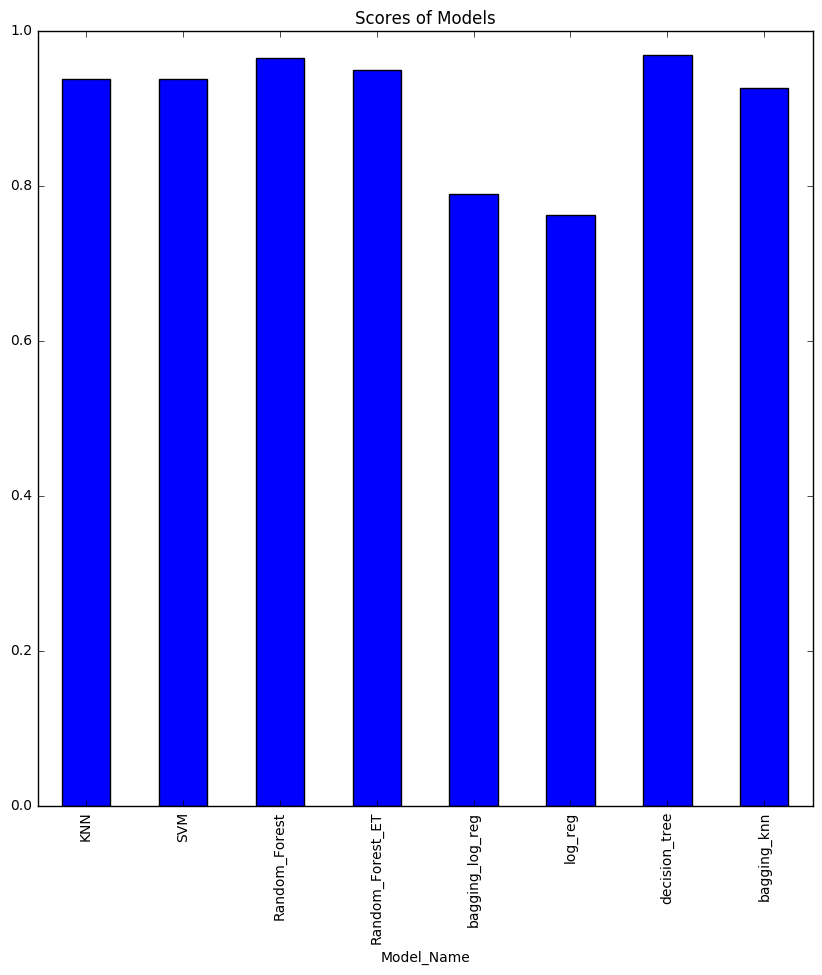

In [64]:
listy_dicty_scores = []

for x in dicty_models.keys():
    listy_dicty_scores.append({
        'Model_Name': x,
        'Score': dicty_models[x].score(X_test, y_test)
        })

df_scores = pd.DataFrame(listy_dicty_scores)
df_scores.head()
df_scores.plot(x='Model_Name', y='Score', kind='bar', legend=False, title='Scores of Models', figsize=(10,10))
print "Winner is decision tree barely"
plt.show()

## Bonus

We have encoded the data using a map that preserves the scale.
Would our results have changed if we had encoded the categorical data using `pd.get_dummies` or `OneHotEncoder`  to encode them as binary variables instead?

1. Repeat the analysis for this scenario. Is it better?
- Experiment with other models or other parameters, can you beat your classmates best score?